In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split



In [2]:
training_vars = ['jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']


# Load Data

In [3]:
sample_path = '../../samples/sample_1500_2p8M_jets.pkl'
sample = pd.read_pickle(sample_path)

In [4]:
sample.columns

Index(['jet_pt', 'jet_eta', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1',
       'jet_trackBDT', 'jet_PartonTruthLabelID', 'equal_weight',
       'event_weight', 'flatpt_weight', 'target'],
      dtype='object')

# Train with default config

In [5]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [6]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [7]:
X_train[training_vars].head()

,jet_nTracks,jet_trackWidth,jet_trackC1
2990151,25.0,0.067243,0.246227
5619014,43.0,0.039205,0.212714
1762478,26.0,0.044914,0.239314
15574,13.0,0.009463,0.130402
341104,26.0,0.041482,0.194124


In [8]:
X_train[training_weight].head()

,equal_weight
2990151,1.0
5619014,1.0
1762478,1.0
15574,1.0
341104,1.0


In [9]:
dt = DecisionTreeClassifier(max_depth=9,
                            min_samples_leaf=0.001,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=42)

bdt.fit(X_train[training_vars], y_train, sample_weight=X_train[training_weight].to_numpy().flatten())

### 27m

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=9,
                                                         max_features='log2',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.1, n_estimators=500, random_state=42)

In [10]:
bdt_filename = './BDT_explore_1500_ntrk_equalweight.model'
pickle.dump(bdt, open(bdt_filename, 'wb'))

# Predict on test datasets

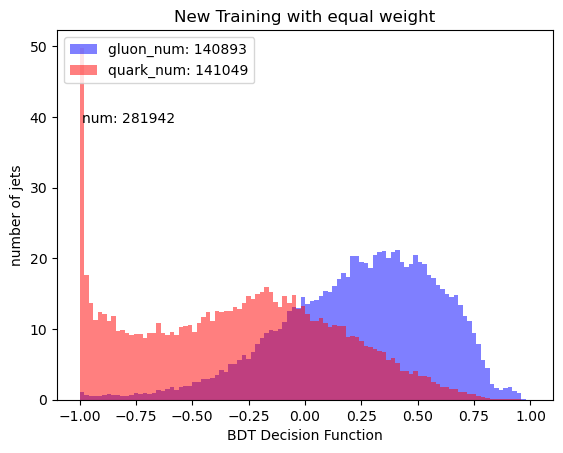

In [11]:
y_test_decisions = bdt.decision_function(X_test[training_vars])
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 101)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with equal weight")
plt.show()

# ROC

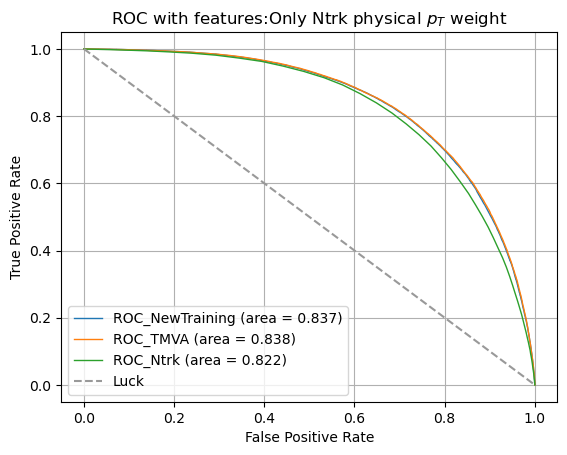

In [12]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig("ROC_physicalweight.png")
    plt.show()

Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')] , y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], X_weight=X_test['event_weight'], features="Only Ntrk")


# Overtrain validation

In [13]:
y_test_decisions = bdt.decision_function(X_test[training_vars])
y_train_decisions = bdt.decision_function(X_train[training_vars])


y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)

Text(0.5, 1.0, 'Overtraining test')

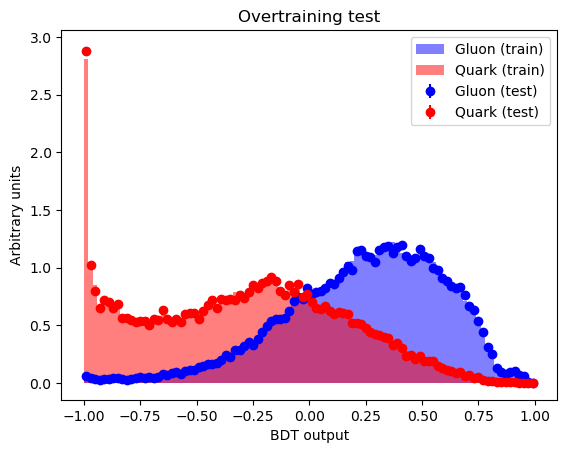

In [14]:
custom_bins = np.linspace(-1, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(decisions[0], weights = X_train.iloc[np.where(y_train==1)[0], event_weight_idx],
            color='b', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Gluon (train)')
ax.hist(decisions[1], weights = X_train.iloc[np.where(y_train==0)[0], event_weight_idx],
            color='r', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Quark (train)')

hist, bins = np.histogram(decisions[2], weights=X_test.iloc[np.where(y_test==1)[0], event_weight_idx],
                            bins=custom_bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='b', label='Gluon (test)')

hist, bins = np.histogram(decisions[3], weights=X_test.iloc[np.where(y_test==0)[0], event_weight_idx],
                            bins=custom_bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='r', label='Quark (test)')
plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")

# Backup

Text(0.5, 1.0, 'Overtraining test')

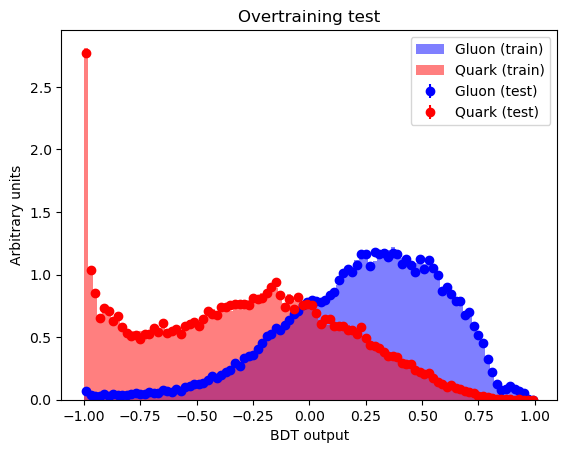

In [15]:
y_test_decisions = bdt.decision_function(X_eval[training_vars])

y_test_decisions_gluon = y_test_decisions[np.where(y_eval==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_eval==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)


custom_bins = np.linspace(-1, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(decisions[0], weights = X_train.iloc[np.where(y_train==1)[0], event_weight_idx],
            color='b', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Gluon (train)')
ax.hist(decisions[1], weights = X_train.iloc[np.where(y_train==0)[0], event_weight_idx],
            color='r', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Quark (train)')

hist, bins = np.histogram(decisions[2], weights=X_eval.iloc[np.where(y_eval==1)[0], event_weight_idx],
                            bins=custom_bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='b', label='Gluon (test)')

hist, bins = np.histogram(decisions[3], weights=X_eval.iloc[np.where(y_eval==0)[0], event_weight_idx],
                            bins=custom_bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='r', label='Quark (test)')
plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")



In [16]:
bins = [[0.3, 0.5, 0.7], [0.3, 0.7]]
values = np.random.random((10, 2))
digitized = []
for i in range(len(bins)):
    digitized.append(np.digitize(values[:, i], bins[i], right=False))
digitized = np.concatenate(digitized).reshape(10, 2)

In [17]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(0, 1, 101)
plt.hist(y_test_proba[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_proba[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Probability")
plt.ylabel("number of jets")
plt.title(r"New Training with event weight")
plt.show()


NameError: name 'y_test_proba' is not defined